In [1]:
!pip install -U sentence-transformers

In [2]:
!pip install pyLDAvis

# Methodology

In [3]:
import pandas as pd
import zipfile
from google.colab import drive

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import collections
import wordcloud
from sentence_transformers import SentenceTransformer
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import spacy
import gensim
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel, Phrases, LdaModel
import pyLDAvis
import pyLDAvis.gensim_models
import os
import time
from tqdm import tqdm
import warnings
from collections import Counter
from nltk.tokenize import ToktokTokenizer
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, show, output_notebook
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [5]:
drive.mount('/content/drive/', force_remount=True)
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/ML/tokenized.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Mounted at /content/drive/


In [6]:
data = pd.read_csv('/tmp/tokenized.csv')
data.head()

title  ...                                      phrase-tokens
0  Surgical Performance Is Not Negatively Impacte...  ...  ['background', 'shortag_suppli', 'equip', 'ide...
1  Indications for Inpatient Magnetoencephalograp...  ...  ['method', 'local', 'zone', 'area', 'part', 'e...
2  Information about COVID-19 for deaf people: an...  ...  ['video', 'inform', 'sign', 'languag', 'studi'...
3  The Association Between Health Status and Inso...  ...  ['object', 'studi', 'mediat', 'role', 'fear', ...
4  Therapeutic targeting of interleukin-6 for the...  ...  ['diseas', 'infect', 'respiratori_syndrom', 'c...

[5 rows x 4 columns]

## Baseline Model using Latent Dirichlet Allocation

In [7]:
def Convert(string):
    li = list(string.split(" "))
    return li

for i in range(len(data)):
  data['tokens'][i] = Convert(data['tokens'][i].replace("[",'').replace("]",'').replace("'",'').replace(',',''))

In [8]:
data_lemmatized = list(data['tokens'])
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 3), (12, 1), (13, 1), (14, 1), (15, 2), (16, 8), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 3), (24, 1), (25, 2), (26, 2), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 2), (39, 1)]]


- How to read: Example (0,1), it means word 0 appears 1 time in the first documents, and so on.

In [21]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=98,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.45668993698418403


## Finding The Optimal Number Of Topics

100%|██████████| 6/6 [33:58<00:00, 339.74s/it]

Topic number selection took 2038.4375948905945 seconds


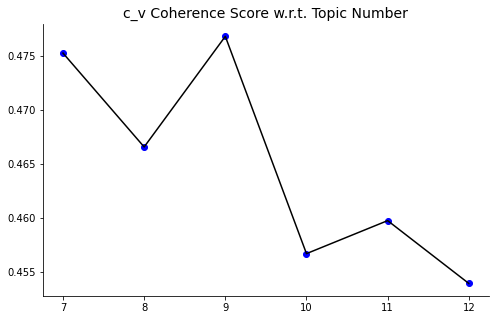

In [29]:
id2token_risk_article = corpora.Dictionary(list(data['tokens']))

corpus_risk_article = [id2token_risk_article.doc2bow(tokens) 
                        for tokens in list(data['tokens'])]

begin_time = time.time()
coherence_scores = []
for nb_topics in tqdm(range(7,13)):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_risk_article,
                            id2word=id2token_risk_article,
                            num_topics=nb_topics, 
                            random_state=98,
                            chunksize=100,
                            passes=10,
                            iterations=50,
                            decay=0.5,
                            per_word_topics=True,)
 
    cm = CoherenceModel(model=lda_model, 
                        texts=list(data['tokens']),
                        dictionary=id2token_risk_article,
                        coherence='c_v',
                        topn=20)
    coherence_score = cm.get_coherence()
    coherence_scores.append(coherence_score)
    
print(f'Topic number selection took {time.time()-begin_time} seconds')

fig,ax = plt.subplots(figsize=(8,5))
ax.plot(range(7,13),coherence_scores,color='black') 
ax.scatter(range(7,13),coherence_scores,marker='o',color='blue')
ax.set_xticks(range(7,13,1))
ax.set_title('c_v Coherence Score w.r.t. Topic Number',fontsize=14)
#ax.set_xlabel('Number of Topics',fontsize=14) 
for pos in ['top','right']:
    ax.spines[pos].set_color(None)

- From the plot above we can see a correlation between **Coherence Score with Topic Number**, higher Coherence Score means better model. As we can see, our baseline model use 10 topic, and from this plot I will take 9 topic number since it produce highest coherence score among the other

- From the graph above, we can see that 12 number of topic also has a great score. But since the score is not too far from 9, I will take 9 number of topics

### Creating LDA model with tuned number of topics

- It seems that 9 number of topic gain the highest score on coherence score.

In [20]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=9, 
                                       random_state=98,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4768420669045713


## Word per Topic

In [13]:
lda_model.show_topics(num_words=15)

[(0,
  '0.097*"patient" + 0.023*"diseas" + 0.022*"studi" + 0.015*"result" + 0.015*"treatment" + 0.014*"risk" + 0.013*"group" + 0.013*"case" + 0.013*"mortal" + 0.013*"infect" + 0.012*"outcom" + 0.012*"hospit" + 0.012*"conclus" + 0.011*"symptom" + 0.011*"day"'),
 (1,
  '0.044*"cell" + 0.021*"protein" + 0.020*"activ" + 0.017*"gene" + 0.016*"respons" + 0.014*"express" + 0.014*"mechan" + 0.012*"role" + 0.011*"effect" + 0.011*"function" + 0.011*"receptor" + 0.011*"diseas" + 0.010*"target" + 0.009*"host" + 0.009*"interact"'),
 (2,
  '0.033*"health" + 0.031*"studi" + 0.018*"particip" + 0.017*"result" + 0.014*"factor" + 0.013*"survey" + 0.012*"level" + 0.011*"peopl" + 0.011*"anxieti" + 0.011*"risk" + 0.011*"group" + 0.010*"children" + 0.010*"impact" + 0.009*"effect" + 0.009*"data"'),
 (3,
  '0.043*"student" + 0.028*"cancer" + 0.026*"educ" + 0.019*"program" + 0.017*"learn" + 0.017*"univers" + 0.016*"school" + 0.016*"experi" + 0.013*"research" + 0.010*"institut" + 0.008*"onlin" + 0.007*"practic" 

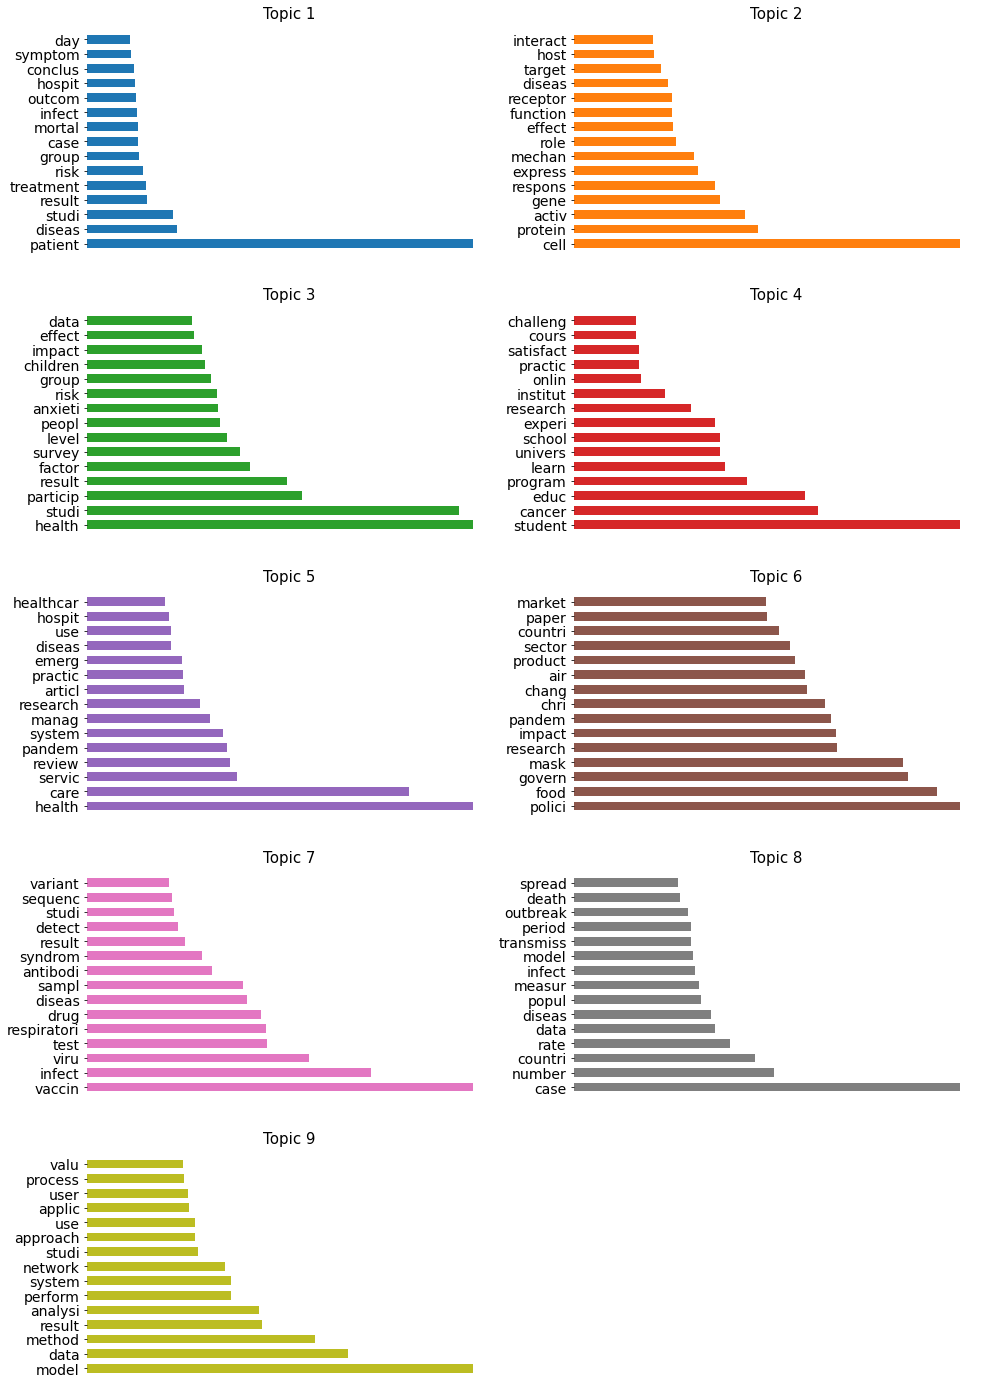

In [14]:
word_topic_scores = lda_model.show_topics(num_words=15,formatted=False)

fig = plt.figure(figsize=(16,25))
for i,topic in enumerate(word_topic_scores):
    word_score_pairs = topic[1]
    words = [word_score_pair[0] for word_score_pair in word_score_pairs]
    probs = [word_score_pair[1] for word_score_pair in word_score_pairs]
    ax = fig.add_subplot(5,2,i+1)
    ax.barh(y=words,width=probs,height=0.6,color=sns.color_palette()[i])
    ax.set_yticklabels(labels=words, fontsize=14) 
    ax.set_xticks([])
    ax.set_title(f'Topic {i+1}',fontsize=15)
    for pos in ['left','right','bottom','top']:
        ax.spines[pos].set_color(None)

- Topic 1 probably talk about **Patient Mortality**, since we can see words like "diseas", "risk", "patient", "mortal"
- Topic 2 probably talk about **Virus Life Cycle**, since we can see words like "interact", "activ", "protein"
- Topic 3 probably talk about **Mental Health During Pandemic**, since we can see words like "mental", "anxieti", "health"
- Topic 4 probably talk about **Study Activity During Pandemic**, since we can see words like "school", "onlin",  "educ"
- Topic 5 probably talk about **Public Health Mitigation**, since we can see words like "hospit", "healthcar", "service"
- Topic 6 probably talk about **Social Effect On Pandemic**, since we can see words like "govern","pandem","impact"
- Topic 7 probably talk about **Study about Infection**, since we can see words like "studi", "infect",  "report"
- Topic 8 probably talk about **Transmission Dynamic On Virus**, since we can see words like "transmiss", "outbreak", "spread"
- Topic 9 probably talk about **Analysis and Modelling Technology**, since we can see words like "model", "data", "analysi"




## Visualize Topics

In [15]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

In [16]:
pyLDAvis.display(LDAvis_prepared)

## Topic Per Document

In [17]:
document_topic_distribution = []
num_topic_document = []
topic_frequency = {}
for i in range(len(corpus)):
    document_topic = lda_model.get_document_topics(corpus[i])
    document_topic_distribution.append(document_topic)
    num_topic_document.append(len(document_topic))
    for topic_idx,prob in document_topic:
        if topic_idx not in topic_frequency:
            topic_frequency[topic_idx] = 1
        else:
            topic_frequency[topic_idx] += 1

topic_frequency = dict(sorted(topic_frequency.items()))

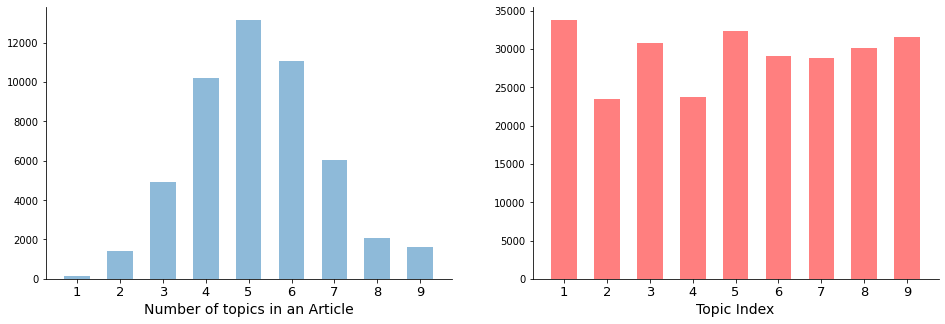

In [18]:
num_topic_document_counter = (pd.DataFrame(num_topic_document)).value_counts(sort=False)
counter_idx = [str(idx[0]) for idx in num_topic_document_counter.index]
counter_values = num_topic_document_counter.values
fig,axes = plt.subplots(figsize=(16,5),nrows=1,ncols=2)
axes[0].bar(counter_idx, counter_values,width=0.6,alpha=0.5)
axes[0].set_xlabel('Number of topics in an Article',fontsize=14)

df_topic_frequency = pd.DataFrame.from_dict(topic_frequency,orient='index')
topic_idxs = [str(idx+1) for idx in df_topic_frequency.index]
axes[1].bar(topic_idxs, df_topic_frequency.iloc[:,0], width=0.6,color='red',alpha=0.5)
axes[1].set_xlabel('Topic Index',fontsize=14)

for ax in axes:
    for pos in ['top','right']:
        ax.spines[pos].set_color(None)
    ax.set_xticklabels(['1','2','3','4','5','6','7','8','9'],fontsize=13)

- Left figure tells us that there are very few articles that cover all the nine topics or one topics
- Right Figure tells us that occurences frequencies of topics are very close since the bar's height is overall same

In [19]:
document_topic_matrix = np.zeros((len(corpus),9))
for idx,document_topic in enumerate(document_topic_distribution):
    for topic_idx,prob in document_topic:
        document_topic_matrix[idx][topic_idx] = prob
pd.DataFrame(document_topic_matrix).head()

0         1         2  ...         6         7         8
0  0.000000  0.000000  0.117591  ...  0.021097  0.000000  0.140189
1  0.282566  0.049439  0.062737  ...  0.000000  0.166539  0.000000
2  0.317853  0.082434  0.000000  ...  0.000000  0.104656  0.218215
3  0.024537  0.000000  0.880698  ...  0.000000  0.000000  0.000000
4  0.115940  0.509434  0.000000  ...  0.359118  0.000000  0.000000

[5 rows x 9 columns]

- Each index document have 9 probability of topics, highest of the probability more likely be the topic of the article

## TSNE for Clustering Visualization on LDA

In [22]:
tSNE = TSNE(n_components=2,init='pca',random_state=98)
embedding_matrix = tSNE.fit_transform(document_topic_matrix)
df_embedding = pd.DataFrame(embedding_matrix, columns=['X_TSNE','Y_TSNE'])
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 
                  3: 'red', 4: 'skyblue', 5:'salmon',
                 6:'pink', 7:'purple', 8:'black',
                 9: 'gold', 10:'lightgreen'}
df_embedding['dominant_topic_idx'] = np.argmax(document_topic_matrix,axis=1)
df_embedding['color'] = df_embedding['dominant_topic_idx'].map(cluster_colors)
cluster_labels = {0: 'Patient Mortality', 1: 'Virus Life Cycle', 2: 'Mental Health During Pandemic', 
                  3: 'Study Activity During Pandemic', 4: 'Public Health Mitigation', 5:'Social Effect On Pandemic',
                 6:'Study about Infection', 7:'Transmission Dynamic On Virus', 8:'Analysis and Modelling Technology'
                 }
df_embedding['label'] = df_embedding['dominant_topic_idx'].map(cluster_labels)
df_embedding['article_title'] = list(data['title'])

output_notebook()

source = ColumnDataSource(
    dict(x = df_embedding['X_TSNE'],
         y = df_embedding['Y_TSNE'],
         color=df_embedding['color'],
         label=df_embedding['label'],
         topic_key= df_embedding['dominant_topic_idx'],
         title= df_embedding['article_title'],
        ))

lda_plot = figure(title='T-SNE Clustering of LDA Topics', 
              plot_width=800, plot_height=600,
              tools='pan,wheel_zoom,box_zoom,reset,hover', 
              x_axis_type=None, y_axis_type=None)
lda_plot.scatter(x='x', y='y', source=source, 
                 legend='label', color='color',alpha=0.7, size=10)
hover = lda_plot.select(dict(type=HoverTool))
hover.tooltips = {'content':'Title: @title'}
lda_plot.legend.location = 'bottom_right'
show(lda_plot)